# Code for Section 3.2.1 Time- and State-Dependent Resampling
This example illustrates how to use the Time- and State-Dependent Resampling method to simulate future paths for the stationary transformations from Section 3.1, computed in the previous code example.

We use the 1m at-the-money foward (ATMF) implied volatility as the state variable and the 25% and 75% percentile values as the J-1=2 partitioning values v_j for the J=3 ranges.

In [1]:
import numpy as np
import pandas as pd
import fortitudo.tech as ft
import matplotlib.pyplot as plt

In [2]:
# Load the time series data and extract 1m ATMF implied vol state variable
time_series = ft.load_time_series()  # to extract the 1m implied vol series used as a state variable
st_df = pd.read_csv('st_df.csv', index_col=0)  # to avoid recomputing the stationary transformations from 3.1
imp_vol_1m = time_series['1m100'].iloc[1:].values

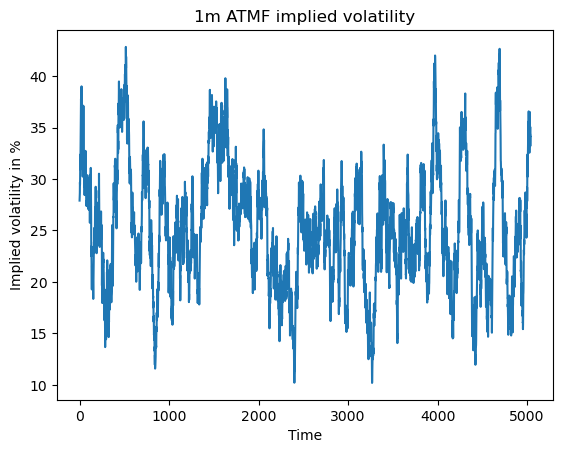

In [3]:
plt.plot(imp_vol_1m)
plt.title('1m ATMF implied volatility')
plt.ylabel('Implied volatility in %')
plt.xlabel('Time')
plt.show()

In [4]:
# Compute percentiles and indices
imp_vol_25pct = np.percentile(imp_vol_1m, 25)
low_vol_indices = imp_vol_1m <= imp_vol_25pct
imp_vol_75pct = np.percentile(imp_vol_1m, 75)
mid_vol_indices = (imp_vol_1m < imp_vol_25pct) ^ (imp_vol_1m <= imp_vol_75pct)
high_vol_indices = imp_vol_1m > imp_vol_75pct

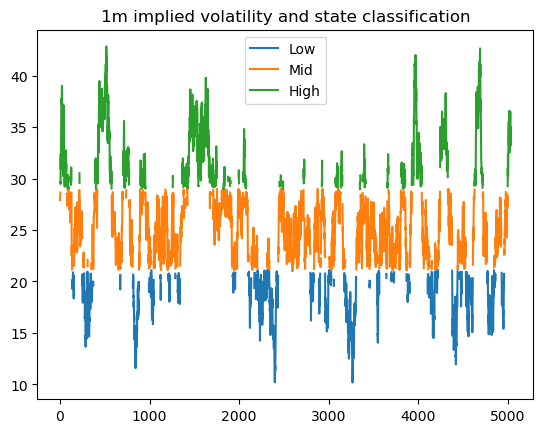

In [5]:
# Plot the 1m implied vol with state classification
vol_low = np.ma.masked_where(low_vol_indices == False, imp_vol_1m)
vol_mid = np.ma.masked_where(mid_vol_indices == False, imp_vol_1m)
vol_high = np.ma.masked_where(high_vol_indices == False, imp_vol_1m)
x = np.arange(0, len(imp_vol_1m))
plt.plot(x, vol_low, x, vol_mid, x, vol_high)
plt.legend(['Low', 'Mid', 'High'])
plt.title('1m implied volatility and state classification')
plt.show()

# Compute scenario probabilities for Time- and State-Dependent Resampling

In [6]:
# Exponential decay prior
p_exp = ft.exp_decay_probs(st_df, half_life=len(st_df) / 2)

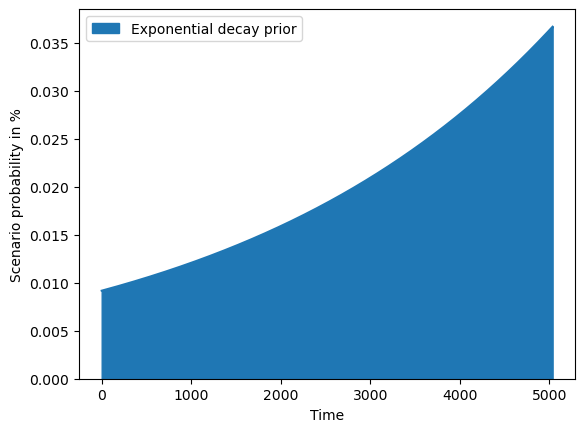

In [7]:
pd.DataFrame(100 * p_exp, columns=['Exponential decay prior']).plot(kind='area')
plt.ylabel('Scenario probability in %')
plt.xlabel('Time')
plt.show()

In [8]:
# Compute view values for Entropy Pooling views
mu_low = np.mean(imp_vol_1m[low_vol_indices])
sigma_low = np.std(imp_vol_1m[low_vol_indices])
mu_mid = np.mean(imp_vol_1m[mid_vol_indices])
sigma_mid = np.std(imp_vol_1m[mid_vol_indices])
mu_high = np.mean(imp_vol_1m[high_vol_indices])
sigma_high = np.std(imp_vol_1m[high_vol_indices])

In [9]:
# Specify left hand sides for Entropy Pooling views
T_tilde = len(st_df)
A = np.vstack((np.ones((1, T_tilde)), imp_vol_1m))  # probabilities sum to 1 and mean
b_low = np.array(([[1.], [mu_low]]))
b_mid = np.array(([[1.], [mu_mid]]))
b_high = np.array(([[1.], [mu_high]]))
G = imp_vol_1m[:, np.newaxis].T ** 2
h_low = np.array([[sigma_low ** 2 + mu_low ** 2]])
h_mid = np.array([[sigma_mid ** 2 + mu_mid ** 2]])
h_high = np.array([[sigma_high ** 2 + mu_high ** 2]])

In [10]:
# Compute Time- and State-Dependent Resampling probability vectors
q_low = ft.entropy_pooling(p_exp, A, b_low, G, h_low)
q_mid = ft.entropy_pooling(p_exp, A, b_mid, G, h_mid)
q_high = ft.entropy_pooling(p_exp, A, b_high, G, h_high)

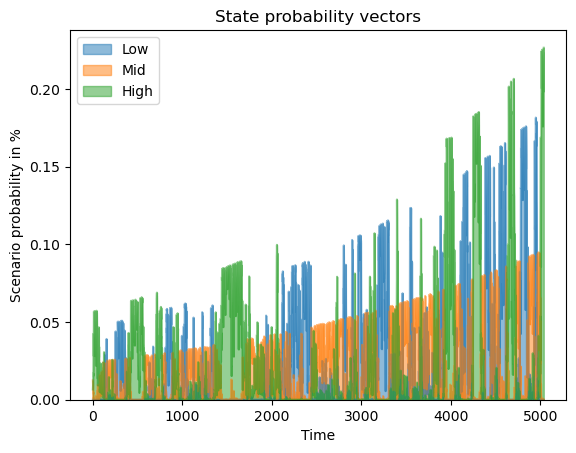

In [11]:
states_prob = 100 * np.hstack((q_low, q_mid, q_high))
pd.DataFrame(states_prob, columns=['Low', 'Mid', 'High']).plot(kind='area', stacked=False)
plt.title('State probability vectors')
plt.xlabel('Time')
plt.ylabel('Scenario probability in %')
plt.show()

# Simulate